In [217]:
import numpy as np, torch
import torch.nn as nn

from PIL import Image
import os
from torchvision.models import ResNet50_Weights

from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from matplotlib.animation import FuncAnimation

NOTE: The code in this Python Notebook will create a folder for GIFs through OS commands in the current working directory. The gifs may display incorrectly in the notebook view. Please check the folder named 'gifs' for an accurate view of the gifs for the second question. 
Please put the test images(named i1.jpg through i5.jpg) in the same directory as this notebook. 

In [218]:
current_directory = os.getcwd()
final_directory = os.path.join(current_directory, r'gifs')
if not os.path.exists(final_directory):
   os.makedirs(final_directory)

updates = ['vanilla', 'momentum', 'nesterov', 'adagrad', 'rmsprop']
for update in updates:
   parent_directory = os.path.join(current_directory, r'gifs')
   final_dir = os.path.join(parent_directory, r''+str(update))
   if not os.path.exists(final_dir):
      os.makedirs(final_dir)

model_rsn50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

<font size='6'> PART A<font size='6'>

<font size='5'>a) Vanilla Backpropagation<font size='5'>

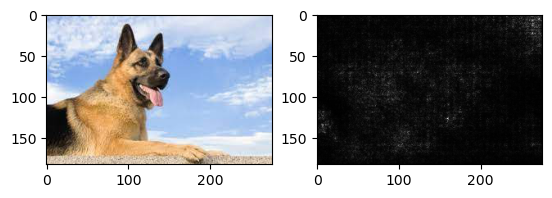

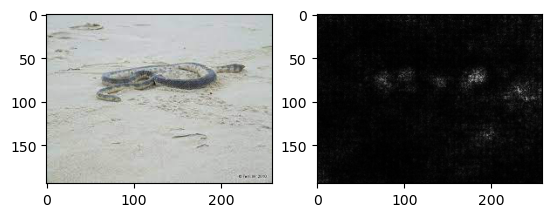

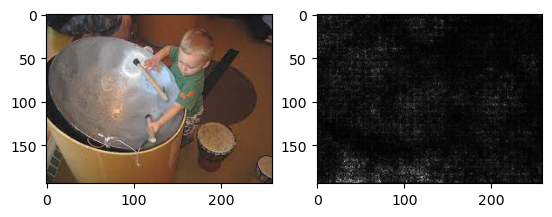

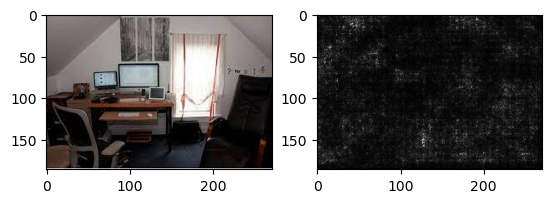

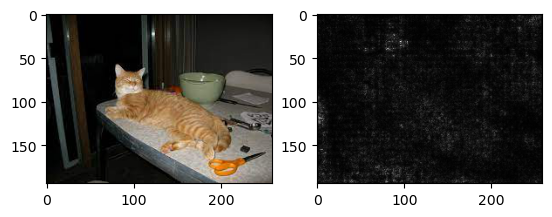

In [219]:

def vanilla_grads(image, model): #input is a pillow image 
    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()

    make_tensor = transforms.ToTensor()
    imagetensor = make_tensor(image)

    means = list(torch.mean(imagetensor, dim=[1,2]))
    stds = list(torch.std(imagetensor, dim = [1,2]))

    normalize = transforms.Normalize(mean = means, std=stds)

    normimg = normalize(imagetensor)
    input = normimg


    input.unsqueeze_(0)

    input.requires_grad = True

    output = model(input)

    prediction, _ = torch.max(output, 1)

    prediction.backward()

    map, _ = torch.max(torch.abs(input.grad[0]), dim=0)

    input.detach()

    return map
    

def show_map(input, map):
    
    img = np.asarray(input)
   
    plt.figure()
    plt.subplot(121)

    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(map.numpy(), cmap=plt.cm.gray)
    plt.show()

for i in range(5):
    im = Image.open(f'i{i+1}.jpg')
    vanilla_map = vanilla_grads(im, model_rsn50)
    show_map(im, vanilla_map)

<font size='5'>b) Guided Backpropagation<font size='5'>

c:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


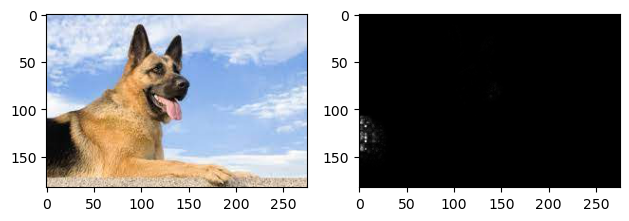

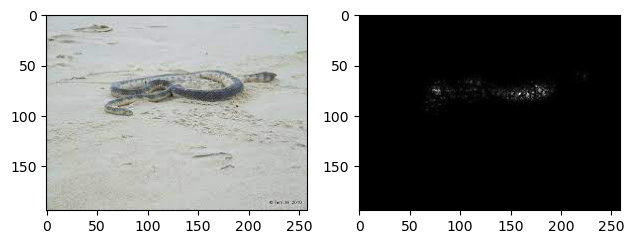

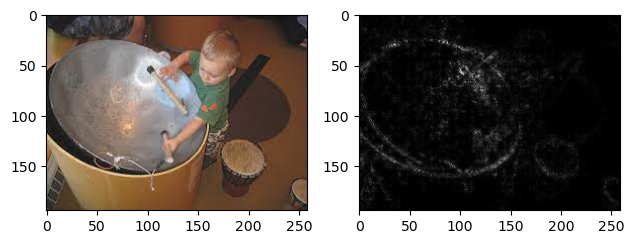

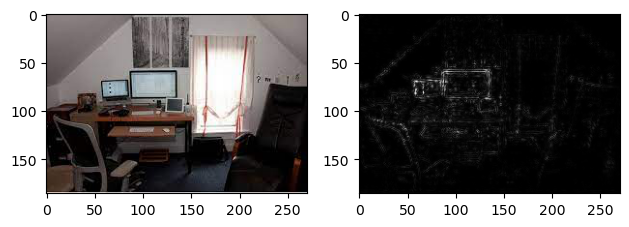

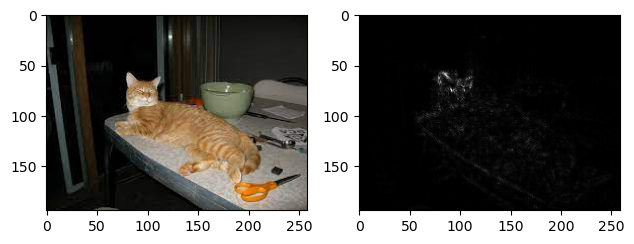

In [220]:
def relu_hook(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),) #used to implement ReLU by clamping all input between (0, inf)

def guided_bpp_gradients(image, model):
    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()

    make_tensor = transforms.ToTensor()
    imagetensor = make_tensor(image)

    


    means = list(torch.mean(imagetensor, dim=[1,2]))
    stds = list(torch.std(imagetensor, dim = [1,2]))

    normalize = transforms.Normalize(mean = means, std=stds)

    normimg = normalize(imagetensor)
    input = normimg


    input.unsqueeze_(0)

    for i, module in enumerate(model.modules()):
        if isinstance(module, torch.nn.ReLU):
            module.register_backward_hook(relu_hook)
    
    input.requires_grad = True
    
    output = model(input)

    prediction, _ = torch.max(output, 1)

    prediction.backward()

    map, _ = torch.max(torch.abs(input.grad[0]), dim=0)

    input.detach()

    return map
    
def show_map(input, map):
    
    img = np.asarray(input)
    plt.figure()
    plt.subplot(121)

    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(map.numpy(), cmap=plt.cm.gray)
    plt.tight_layout()
    plt.show()


for i in range(5):
    im = Image.open(f'i{i+1}.jpg')
    guided_map = guided_bpp_gradients(im, model_rsn50)
    show_map(im, guided_map)

<font size='5'>c) Class Activation Map<font size='5'>

<font size='5'>d)Guided Class Activation Map<font size='5'>

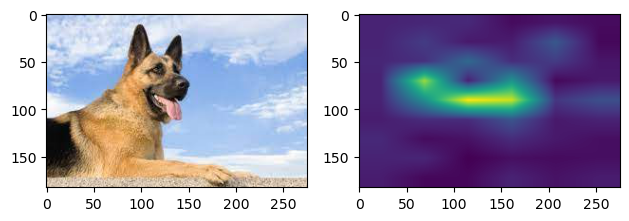

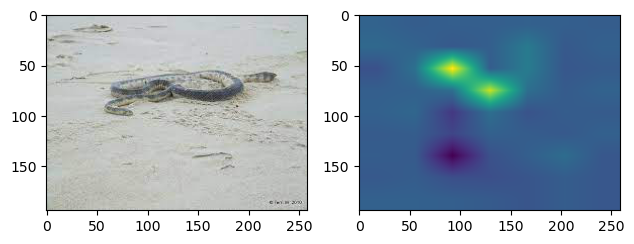

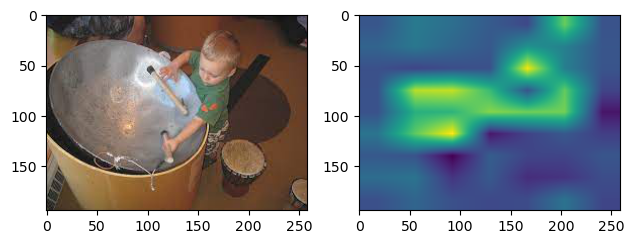

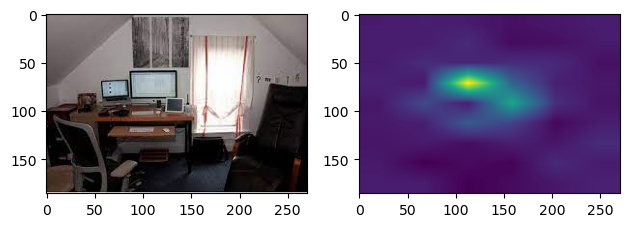

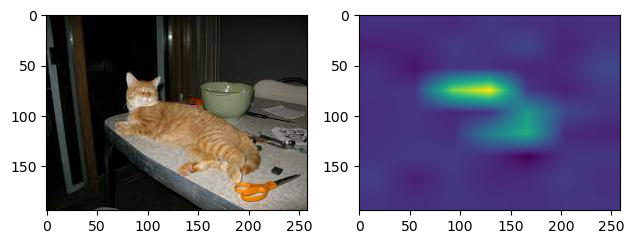

In [221]:
#CAM
resnet50 =  models.resnet50(weights=ResNet50_Weights.DEFAULT)
fc_layer = resnet50.fc
fc_params = list(fc_layer.parameters())
weights = resnet50.state_dict()['fc.weight'].numpy()



def generate_CAM(conv_output_map, weight, class_index, input_size):
    _, channels, h, w = conv_output_map.shape
    
    output = []

    transf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(input_size)
    ])

    for idx in class_index:
        bfd = conv_output_map.reshape((channels, h*w))
        
        map = np.matmul(weight[idx], bfd)
        map = map.reshape(h, w)
        map = (map - np.min(map)) / np.max(map)
        map = np.uint8(255 * map) 
        
        output.append(transf(map).numpy())
    return output

def show_map(input, map):
    
    img = np.asarray(input)
    plt.figure()
    plt.subplot(121)

    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(np.transpose(map, (2,1,0)))
    plt.tight_layout()
    plt.show()


for i in range(5):
    img = Image.open('i'+str(i+1)+'.jpg')

    tf = transforms.ToTensor()
    imgtensor = tf(img)
    imgtensor.unsqueeze_(0)
    modeloutput = resnet50(imgtensor)

    softmax_op = torch.nn.functional.softmax(modeloutput, dim=1).data.squeeze()

    probabilities, index = softmax_op.sort(0, True)
    probabilities = probabilities.numpy()
    index = index.numpy()

    model_no_fc = nn.Sequential(*list(resnet50.children())[:-2])

    conv_op = model_no_fc(imgtensor).detach().numpy()
    #print(index[0])
    CAM_list = generate_CAM(conv_op, weights, [index[0]], img.size)

    show_map(img, CAM_list[0])
    

    

    



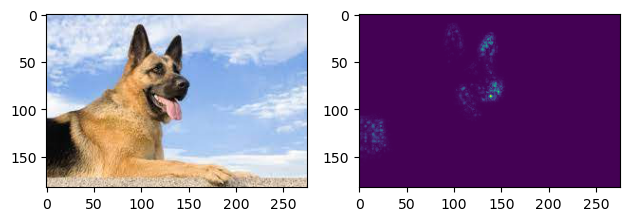

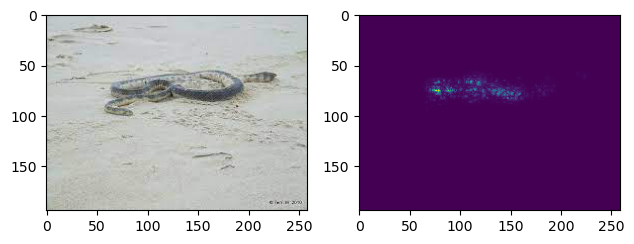

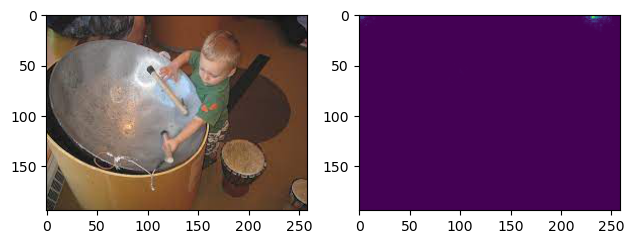

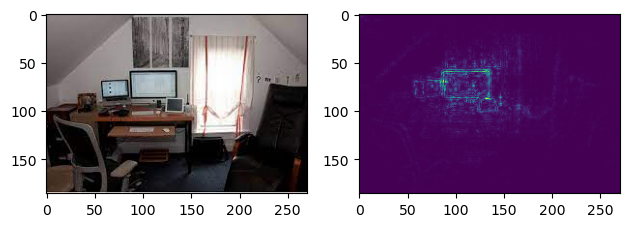

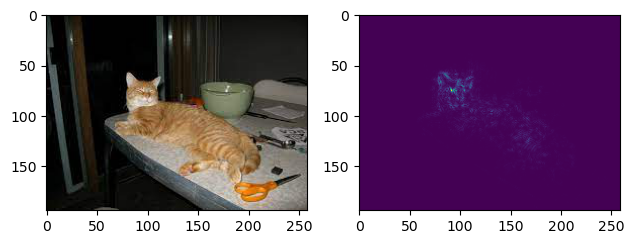

In [222]:
for i in range(5):
    img= Image.open('i'+str(i+1)+'.jpg')

    gbpp = guided_bpp_gradients(img, resnet50)

    tf = transforms.ToTensor()
    imgtensor = tf(img)
    imgtensor.unsqueeze_(0)
    modeloutput = resnet50(imgtensor)

    softmax_op = torch.nn.functional.softmax(modeloutput, dim=1).data.squeeze()

    probabilities, index = softmax_op.sort(0, True)
    probabilities = probabilities.numpy()
    index = index.numpy()

    model_no_fc = nn.Sequential(*list(resnet50.children())[:-2])

    conv_op = model_no_fc(imgtensor).detach().numpy()

    CAM_list = generate_CAM(conv_op, weights, [index[0]], img.size)

    cm = CAM_list[0]



    guidedgradcam = np.multiply(gbpp, np.transpose(cm, (2,1,0))[:, :, 0])



    plt.figure()
    plt.subplot(121)

    plt.imshow(np.asarray(img))
    plt.subplot(122)
    plt.imshow(guidedgradcam)
    plt.tight_layout()
    plt.show()


<font size="6">PART 2<font size="6">

<font size="5">a) Vanilla SGD<font size="5">

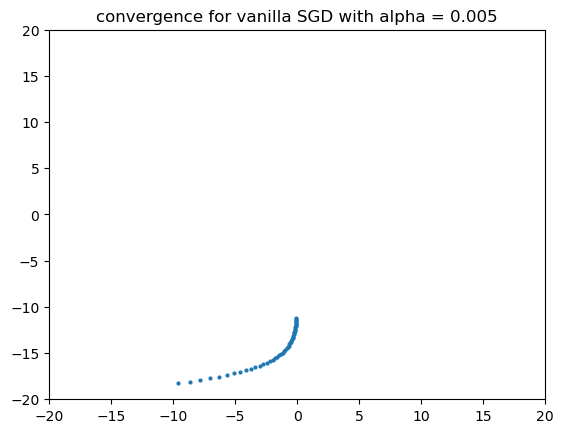

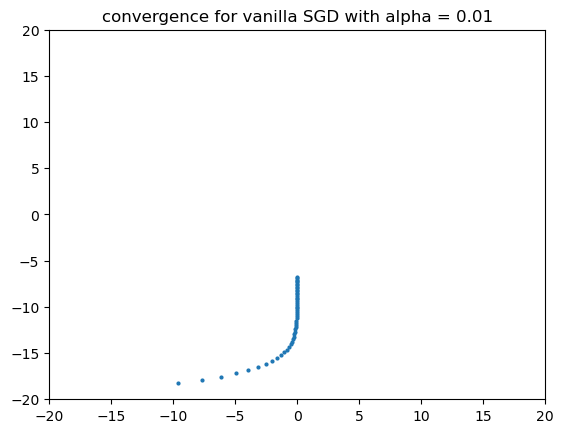

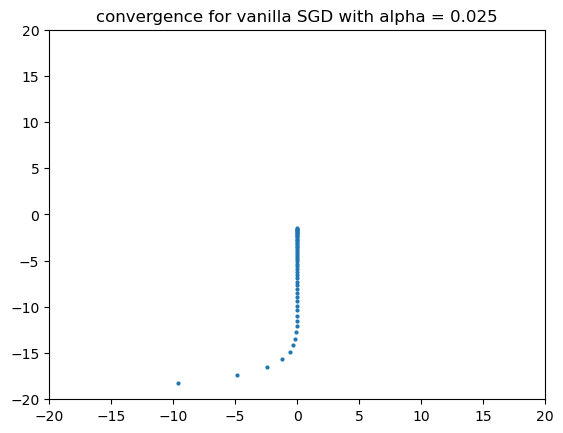

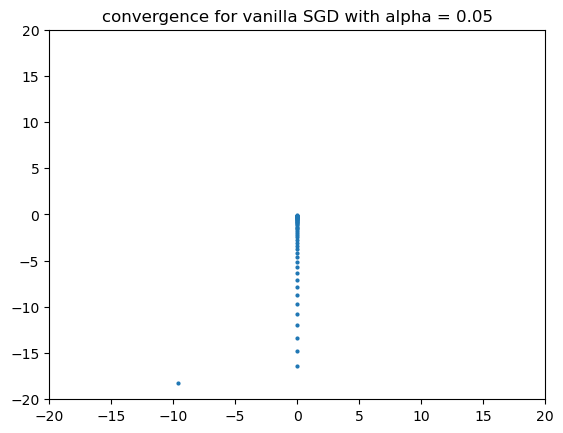

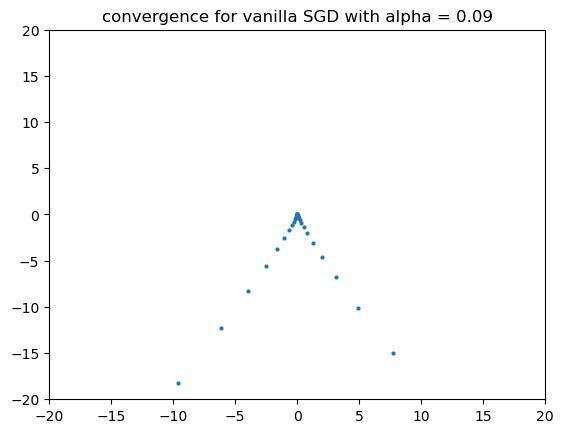

In [223]:
np.random.seed(68)
x_init = np.random.uniform(-20, 20)
y_init = np.random.uniform(-20, 20)


def function(x, y):
    return 10 * x**2 + y**2

def gradient_x(x,y):
    return 20*x

def gradient_y(x,y):
    return 2 * y


alpha_vals = [0.005, 0.01, 0.025, 0.05, 0.09] # ! HAVING THE LAST VALUE OF LEARNING RATE BE 0.1 MAKES THE POINTS OSCILLATE WITH EQUAL AMPLITUDE AROUND X=0

#now we will take the starting point, find gradient, subtract by learning rate 

x_sets = []
y_sets = []

for alpha in alpha_vals:
    x = x_init
    y = y_init
    x_points = np.zeros(50)
    y_points = np.zeros(50)

    for i in range(50):
        x_points[i] = x
        y_points[i] = y

        grad_x = gradient_x(x,y)
        grad_y = gradient_y(x,y)
        x = x - alpha * grad_x
        y = y - alpha * grad_y
    
    x_sets.append(x_points)
    y_sets.append(y_points)





#PLOTTING CODE 
def show_convergence(x, y, a, figname="default.gif"):
    fig = plt.figure()
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    graph, = plt.plot([], [], 'o', markersize=2)
    def animate(i):
        graph.set_data(x[:i+1], y[:i+1])
        return graph

    ani = FuncAnimation(fig, animate, frames=50, interval=200)
    plt.title("convergence for vanilla SGD with alpha = " + str(alpha_vals[a]))
    ani.save('gifs/vanilla/'+figname)
    
    plt.show()


for i in range(5):
    show_convergence(x_sets[i], y_sets[i], i, 'vanilla_SGD_alpha_'+str(alpha_vals[i])+'.gif')

<font size="5">b) SGD with Momentum<font size="5">

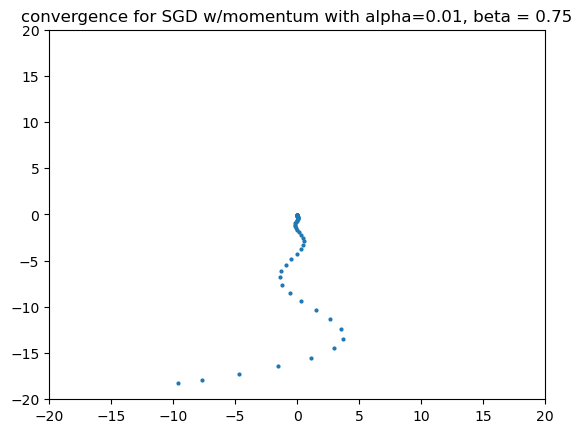

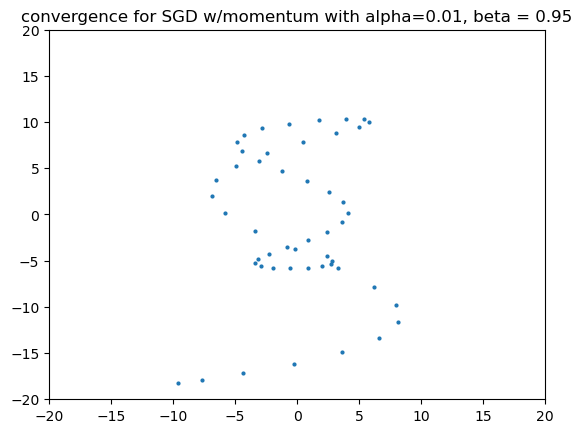

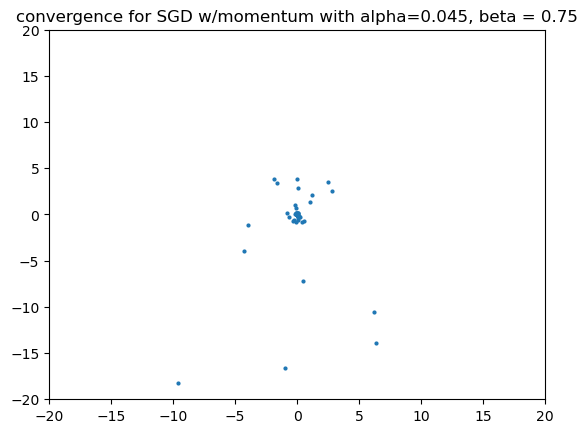

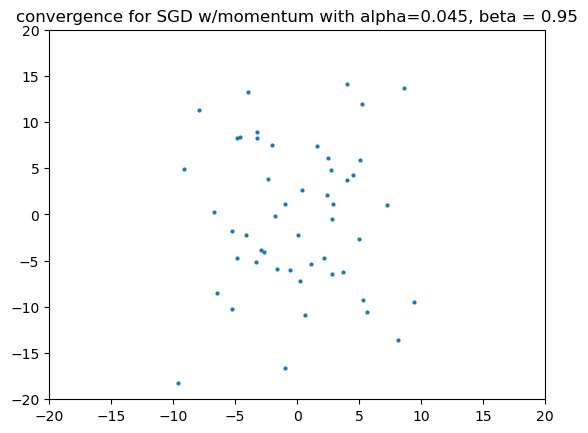

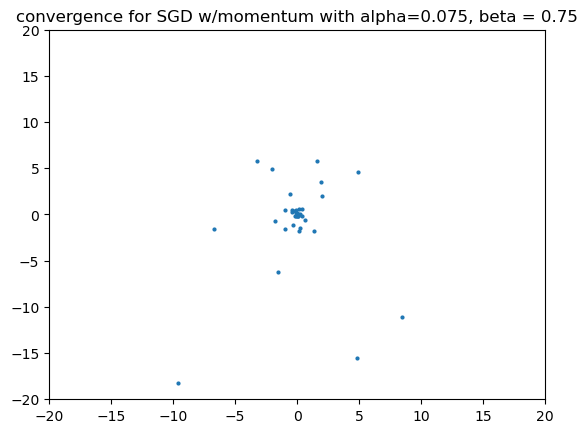

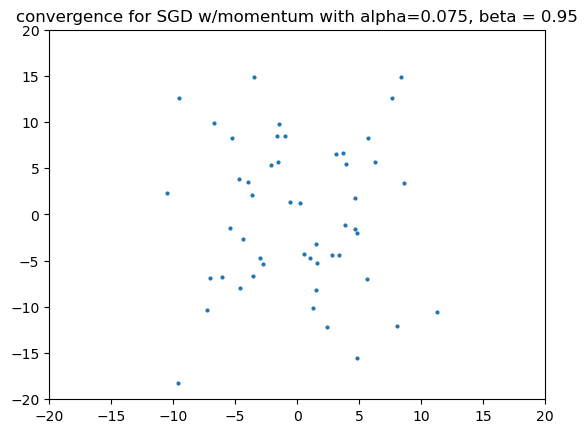

In [224]:
np.random.seed(68)
x_init = np.random.uniform(-20, 20)
y_init = np.random.uniform(-20, 20)


def function(x, y):
    return 10 * x**2 + y**2

def gradient_x(x,y):
    return 20*x

def gradient_y(x,y):
    return 2 * y

alpha_vals = [0.01, 0.045, 0.075]
beta_vals = [0.75, 0.95]


x_sets = []
y_sets = []

for alpha in alpha_vals:
    for beta in beta_vals:
        x = x_init
        y = y_init
        x_points = np.zeros(50)
        y_points = np.zeros(50)

        prev_grad_x = 0
        prev_grad_y = 0
        for i in range(50):
            x_points[i] = x
            y_points[i] = y

            grad_x = gradient_x(x,y)
            grad_y = gradient_y(x,y)
            grad_x = beta * prev_grad_x + grad_x
            grad_y = beta * prev_grad_y + grad_y  
            x = x - alpha * grad_x
            y = y - alpha * grad_y
            prev_grad_x = grad_x
            prev_grad_y = grad_y
        
        x_sets.append(x_points)
        y_sets.append(y_points)






#PLOTTING CODE 
def show_convergence(x, y, a, b, figname="default.gif"):
    fig = plt.figure()
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    graph, = plt.plot([], [], 'o', markersize=2)
    def animate(i):
        graph.set_data(x[:i+1], y[:i+1])
        return graph

    ani = FuncAnimation(fig, animate, frames=50, interval=200)
    plt.title("convergence for SGD w/momentum with alpha=" + str(alpha_vals[a]) + ", beta = " + str(beta_vals[b]))
    ani.save('gifs/momentum/'+figname)
    
    plt.show()

for i in range(3):
    for j in range(2):

        show_convergence(x_sets[2* i + j], y_sets[2* i + j], i, j, 'momentum_SGD_alpha_'+str(alpha_vals[i])+ '_beta_'+str(beta_vals[j])+'.gif')

<font size='5'>c) SGD with Nesterov Momentum<font size='5'>

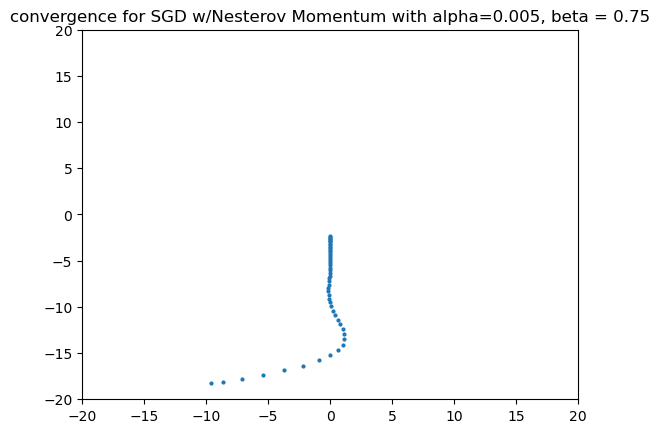

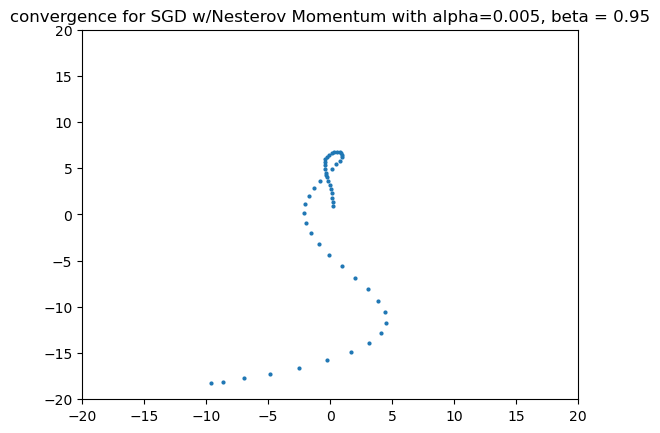

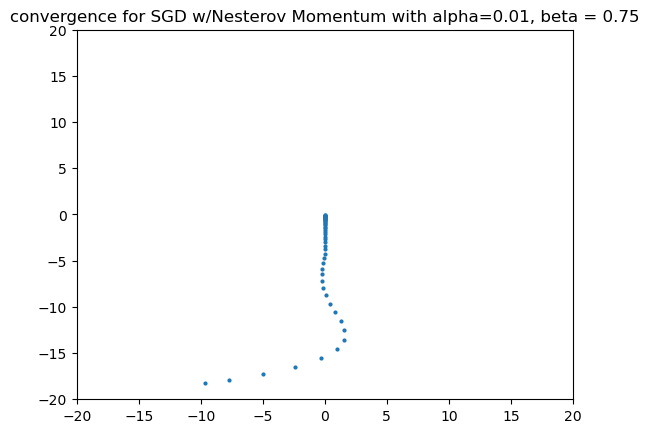

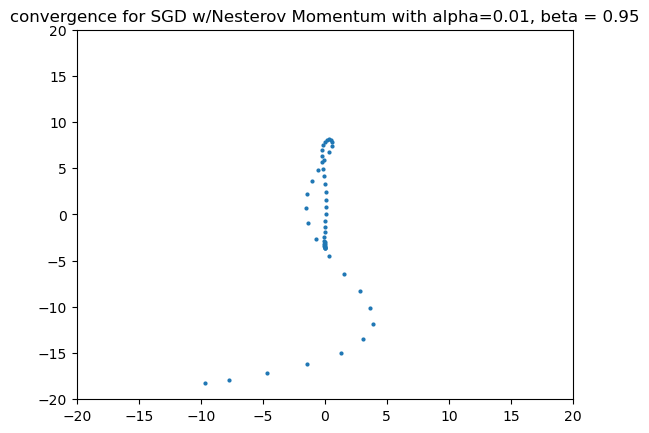

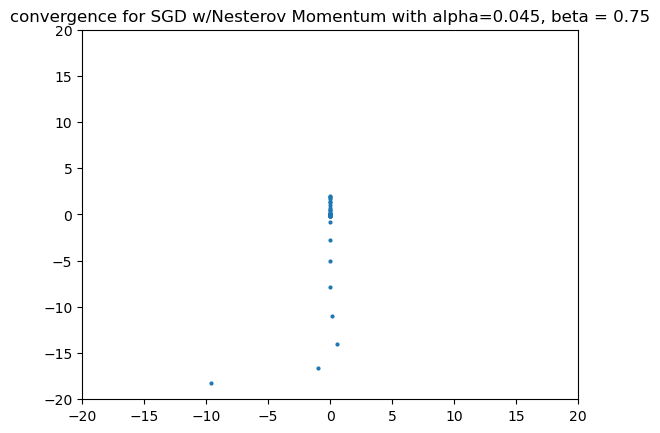

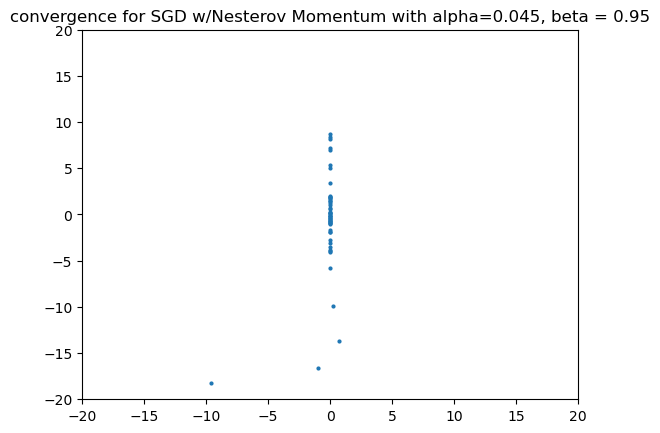

In [225]:
np.random.seed(68)
x_init = np.random.uniform(-20, 20)
y_init = np.random.uniform(-20, 20)


def function(x, y):
    return 10 * x**2 + y**2

def gradient_x(x,y):
    return 20*x

def gradient_y(x,y):
    return 2 * y

alpha_vals = [0.005, 0.01, 0.045]
beta_vals = [0.75, 0.95]


x_sets = []
y_sets = []

for alpha in alpha_vals: 
    for beta in beta_vals: 
        x = x_init
        y = y_init
        x_points = np.zeros(50)
        y_points = np.zeros(50)

        prev_grad_x = 0
        prev_grad_y = 0

        for i in range(50):
            x_points[i] = x
            y_points[i] = y

            x_la = x - beta * prev_grad_x
            y_la = y - beta * prev_grad_y

            grad_x = beta * prev_grad_x + alpha * gradient_x(x_la, y_la)
            grad_y = beta * prev_grad_y + alpha * gradient_y(x_la, y_la)

            x = x - grad_x
            y = y - grad_y

            prev_grad_x = grad_x
            prev_grad_y = grad_y
        
        x_sets.append(x_points)
        y_sets.append(y_points)

        
def show_convergence(x, y, a, b, figname="default.gif"):
    fig = plt.figure()
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    graph, = plt.plot([], [], 'o', markersize=2)
    def animate(i):
        graph.set_data(x[:i+1], y[:i+1])
        return graph

    ani = FuncAnimation(fig, animate, frames=50, interval=200)
    plt.title("convergence for SGD w/Nesterov Momentum with alpha=" + str(alpha_vals[a]) + ", beta = " + str(beta_vals[b]))
    ani.save('gifs/nesterov/'+figname)
    
    plt.show()

for i in range(3):
    for j in range(2):

        show_convergence(x_sets[2* i + j], y_sets[2* i + j], i, j, 'nesterov_SGD_alpha_'+str(alpha_vals[i])+ '_beta_'+str(beta_vals[j])+'.gif')
            
        

<font size='5'>d) AdaGrad<font size='5'>


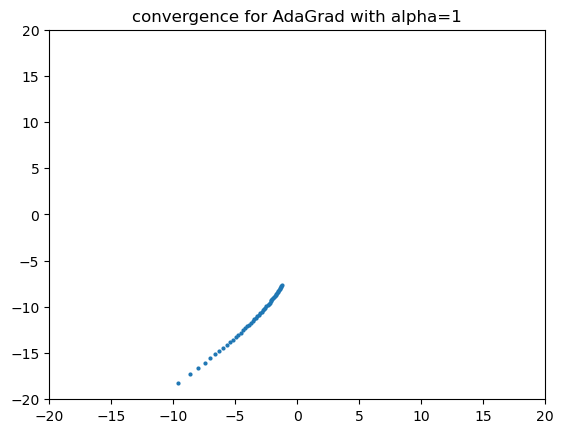

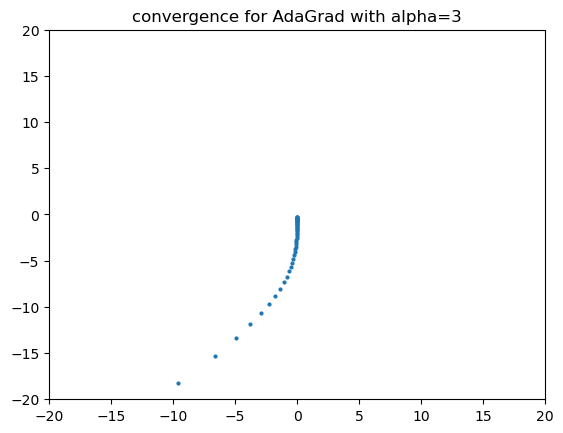

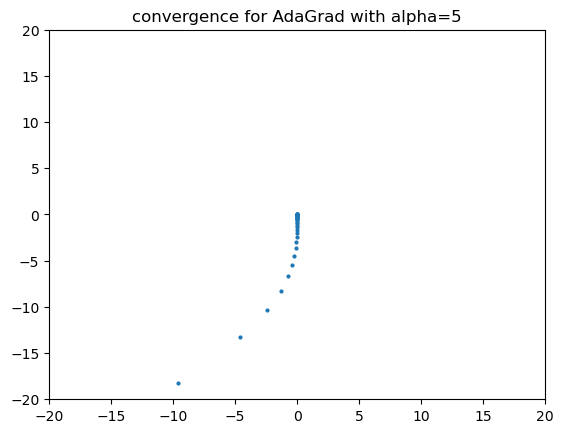

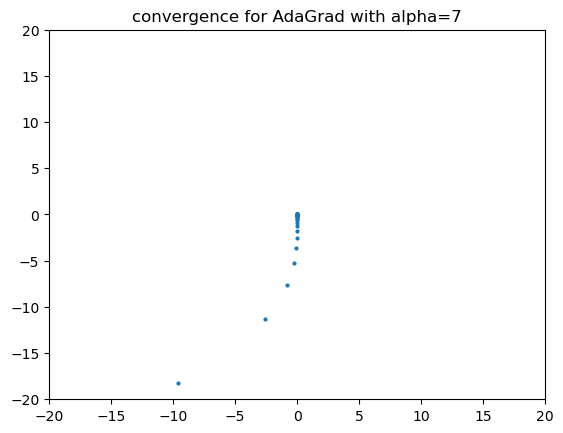

In [226]:
np.random.seed(68)
x_init = np.random.uniform(-20, 20)
y_init = np.random.uniform(-20, 20)


def function(x, y):
    return 10 * x**2 + y**2

def gradient_x(x,y):
    return 20*x

def gradient_y(x,y):
    return 2 * y

alpha_vals = [1, 3, 5, 7]
eps = 1e-7

x_sets = []
y_sets = []

for alpha in alpha_vals: 
    x = x_init
    y = y_init
    x_points = np.zeros(50)
    y_points = np.zeros(50)

    grad_sq_x = 0
    grad_sq_y = 0

    for i in range(50):
        x_points[i] = x
        y_points[i] = y

        grad_x = gradient_x(x, y)
        grad_y = gradient_y(x, y)

        grad_sq_x += grad_x ** 2
        grad_sq_y += grad_y ** 2

        x -= alpha * grad_x / (np.sqrt(grad_sq_x) + eps)
        y -= alpha * grad_y / (np.sqrt(grad_sq_y) + eps)
    x_sets.append(x_points)
    y_sets.append(y_points)


def show_convergence(x, y, a, figname="default.gif"):
    fig = plt.figure()
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    graph, = plt.plot([], [], 'o', markersize=2)
    def animate(i):
        graph.set_data(x[:i+1], y[:i+1])
        return graph

    ani = FuncAnimation(fig, animate, frames=50, interval=200)
    plt.title("convergence for AdaGrad with alpha=" + str(alpha_vals[a]))
    ani.save('gifs/adagrad/'+figname)
    
    plt.show()


for i in range(len(alpha_vals)):
    show_convergence(x_sets[i], y_sets[i], i, 'AdaGrad_alpha_'+str(alpha_vals[i])+'.gif')


<font size='5'>e) RMSProp<font size='5'>

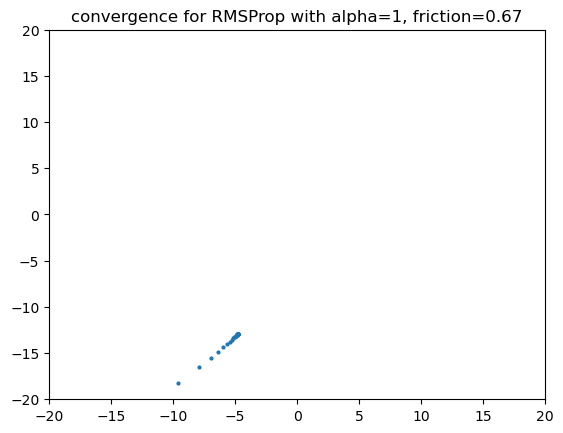

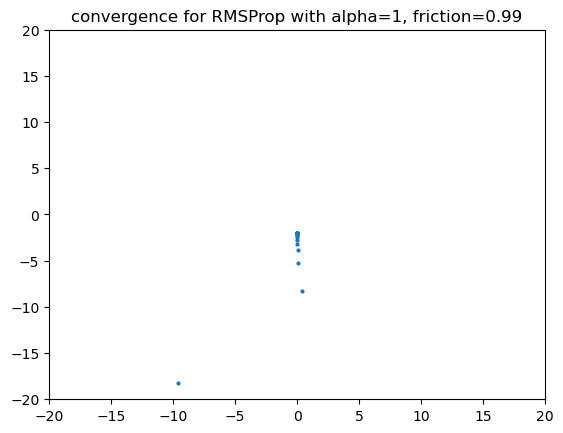

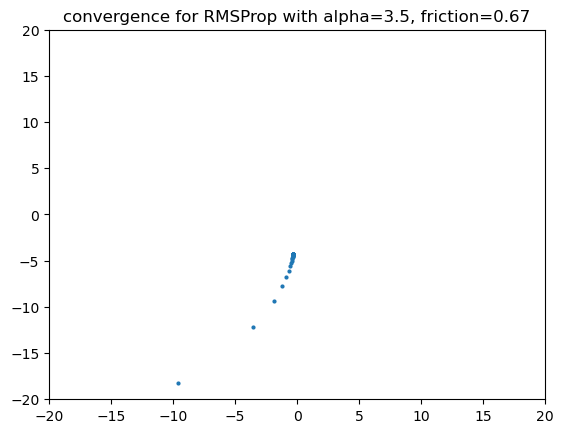

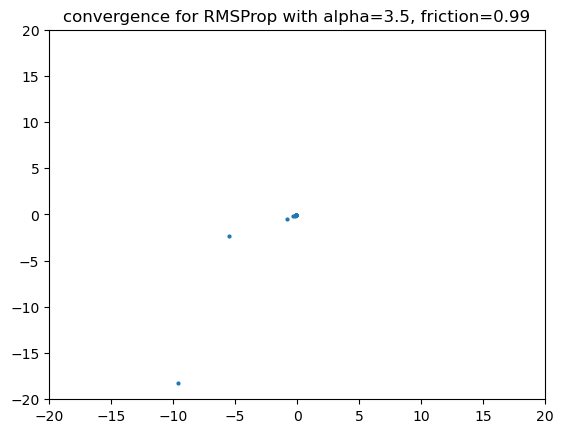

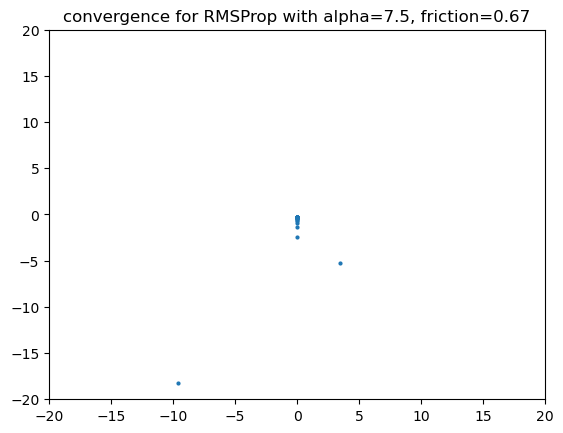

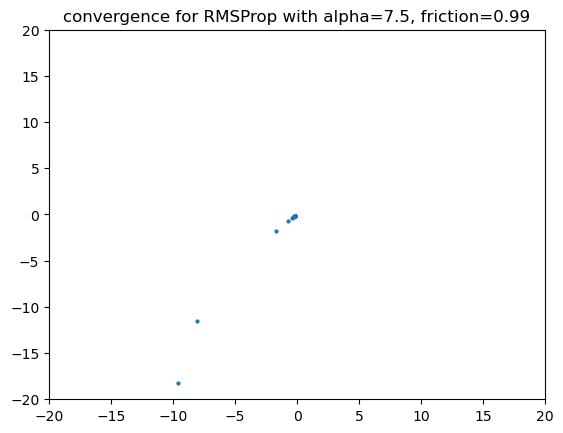

In [227]:
np.random.seed(68)
x_init = np.random.uniform(-20, 20)
y_init = np.random.uniform(-20, 20)


def function(x, y):
    return 10 * x**2 + y**2

def gradient_x(x,y):
    return 20*x

def gradient_y(x,y):
    return 2 * y

alpha_vals = [1, 3.5, 7.5]
eps = 1e-7
friction_vals = [0.67, 0.99]

x_sets = []
y_sets = []

for alpha in alpha_vals: 
    for friction in friction_vals:
        x = x_init
        y = y_init
        x_points = np.zeros(50)
        y_points = np.zeros(50)

        grad_sq_x = 0
        grad_sq_y = 0

        for i in range(50):
            x_points[i] = x
            y_points[i] = y

            grad_x = gradient_x(x, y)
            grad_y = gradient_y(x, y)

            grad_sq_x += friction * grad_sq_x + (1-friction) * (grad_x ** 2)
            grad_sq_y += friction * grad_sq_y + (1-friction) * (grad_y ** 2)

            x -= alpha * grad_x / (np.sqrt(grad_sq_x) + eps)
            y -= alpha * grad_y / (np.sqrt(grad_sq_y) + eps)
        x_sets.append(x_points)
        y_sets.append(y_points)


def show_convergence(x, y, a, b, figname="default.gif"):
    fig = plt.figure()
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    graph, = plt.plot([], [], 'o', markersize=2)
    def animate(i):
        graph.set_data(x[:i+1], y[:i+1])
        return graph

    ani = FuncAnimation(fig, animate, frames=50, interval=200)
    plt.title("convergence for RMSProp with alpha=" + str(alpha_vals[a]) + ", friction=" + str(friction_vals[b]))
    ani.save('gifs/rmsprop/'+figname)
    
    plt.show()


for i in range(len(alpha_vals)):
    for j in range(len(friction_vals)):
        show_convergence(x_sets[2*i + j], y_sets[2*i + j], i, j, 'RMSProp_alpha_'+str(alpha_vals[i])+'_friction_'+str(friction_vals[j])+'.gif')